# <center>German apartment listings over time</center>


## 0) Imports

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

import glob
import concurrent.futures
import time

import dataprocessing as dp

%load_ext nb_black
%matplotlib inline

plt.rcParams["figure.dpi"] = 130
pd.set_option("display.precision", 2)
pd.set_option("display.max_columns", None)

<IPython.core.display.Javascript object>

## 1) Data Engineering

#### find dates:

In [2]:
dates = sorted(
    [
        s[s.find("mieten") + len("mieten") : s.rfind(".csv")]
        for s in glob.glob("../data/mieten*")
    ]
)

<IPython.core.display.Javascript object>

#### load time series dataframe with multithreading:

In [3]:
start = time.perf_counter()
with concurrent.futures.ThreadPoolExecutor() as executor:
    combined_dfs = executor.map(dp.create_combined_df, dates)

time_df = pd.concat(combined_dfs, axis=1)
time_df = time_df.replace([np.inf, -np.inf], np.nan)
time_df = time_df.dropna()

finish = time.perf_counter()
print(f"Loaded in {round(finish-start, 2)} seconds")

Loaded in 29.3 seconds


<IPython.core.display.Javascript object>

#### add columns for change:

In [4]:
startdate = dates[0]
enddate = dates[-1]
time_df["median_yearly_ROI change"] = dp.compute_change(
    time_df, "median_yearly_ROI ", startdate, enddate
)
time_df["median_rent_m2 change"] = dp.compute_change(
    time_df, "median_rent_m2 ", startdate, enddate
)
time_df["num_rent change"] = dp.compute_change(time_df, "num_rent ", startdate, enddate)
time_df["median_price_m2 change"] = dp.compute_change(
    time_df, "median_price_m2 ", startdate, enddate
)
time_df["num_sale change"] = dp.compute_change(time_df, "num_sale ", startdate, enddate)


move_cols = [
    "median_yearly_ROI change",
    "median_rent_m2 change",
    "num_rent change",
    "median_price_m2 change",
    "num_sale change",
]
time_df = time_df[move_cols + [col for col in time_df.columns if col not in move_cols]]

<IPython.core.display.Javascript object>

## 2) Results

### 2.1) Overview

In [5]:
min_num = 5
startdate = dates[0]
enddate = dates[-1]
time_ord = "median_yearly_ROI change"

time_filt = (
    (time_df["num_rent " + startdate] > min_num)
    & (time_df["num_rent " + startdate] > min_num)
    & (time_df["num_sale " + enddate] > min_num)
    & (time_df["num_sale " + enddate] > min_num)
)

time_df[time_filt].sort_values(time_ord, ascending=False)

,median_yearly_ROI change,median_rent_m2 change,num_rent change,median_price_m2 change,num_sale change,median_yearly_ROI 2020-04-07,median_rent_m2 2020-04-07,num_rent 2020-04-07,median_price_m2 2020-04-07,num_sale 2020-04-07,median_yearly_ROI 2020-04-13,median_rent_m2 2020-04-13,num_rent 2020-04-13,median_price_m2 2020-04-13,num_sale 2020-04-13,median_yearly_ROI 2020-04-19,median_rent_m2 2020-04-19,num_rent 2020-04-19,median_price_m2 2020-04-19,num_sale 2020-04-19,median_yearly_ROI 2020-04-28,median_rent_m2 2020-04-28,num_rent 2020-04-28,median_price_m2 2020-04-28,num_sale 2020-04-28,median_yearly_ROI 2020-05-04,median_rent_m2 2020-05-04,num_rent 2020-05-04,median_price_m2 2020-05-04,num_sale 2020-05-04,median_yearly_ROI 2020-05-10,median_rent_m2 2020-05-10,num_rent 2020-05-10,median_price_m2 2020-05-10,num_sale 2020-05-10,median_yearly_ROI 2020-05-19,median_rent_m2 2020-05-19,num_rent 2020-05-19,median_price_m2 2020-05-19,num_sale 2020-05-19,median_yearly_ROI 2020-05-25,median_rent_m2 2020-05-25,num_rent 2020-05-25,median_price_m2 2020-05-25,num_sale 2020-05-25,median_yearly_ROI 2020-06-01,median_rent_m2 2020-06-01,num_rent 2020-06-01,median_price_m2 2020-06-01,num_sale 2020-06-01,median_yearly_ROI 2020-06-08,median_rent_m2 2020-06-08,num_rent 2020-06-08,median_price_m2 2020-06-08,num_sale 2020-06-08,median_yearly_ROI 2020-06-15,median_rent_m2 2020-06-15,num_rent 2020-06-15,median_price_m2 2020-06-15,num_sale 2020-06-15,median_yearly_ROI 2020-06-22,median_rent_m2 2020-06-22,num_rent 2020-06-22,median_price_m2 2020-06-22,num_sale 2020-06-22,median_yearly_ROI 2020-06-29,median_rent_m2 2020-06-29,num_rent 2020-06-29,median_price_m2 2020-06-29,num_sale 2020-06-29
zipCode,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
47229,4.91,1.00,1.25,0.20,1.60,0.03,6.59,24.0,2811.97,5.0,0.03,6.38,29.0,2811.97,5.0,0.03,6.50,24.0,2811.97,5.0,0.05,6.09,23.0,1600.00,9.0,0.06,6.42,24.0,1322.29,10.0,0.06,6.23,24.0,1322.29,10.0,0.09,6.19,24.0,878.63,12.0,0.13,6.40,24.0,576.92,9.0,0.13,6.42,25.0,576.92,9.0,0.14,6.50,27.0,570.55,8.0,0.14,6.56,27.0,564.18,7.0,0.14,6.71,28.0,564.18,7.0,0.14,6.57,30.0,570.55,8.0
24768,2.41,1.06,1.47,0.43,2.25,0.03,6.85,34.0,3163.20,4.0,0.03,6.79,35.0,3163.20,4.0,0.03,6.60,43.0,3163.20,4.0,0.02,7.03,44.0,3545.06,3.0,0.02,6.94,58.0,3545.06,3.0,0.02,6.71,71.0,3545.06,9.0,0.04,6.65,54.0,2482.67,4.0,0.04,6.82,43.0,2482.67,4.0,0.06,6.79,39.0,1420.29,5.0,0.06,6.82,47.0,1388.72,6.0,0.02,7.23,43.0,3537.97,10.0,0.06,7.05,51.0,1330.75,6.0,0.06,7.23,50.0,1357.14,9.0
13359,1.88,1.89,1.11,1.00,1.14,0.02,7.37,9.0,4298.94,29.0,0.02,7.17,8.0,4176.44,28.0,0.02,8.13,9.0,4301.36,31.0,0.02,7.37,9.0,4313.24,32.0,0.02,6.99,7.0,4313.24,32.0,0.03,10.86,13.0,4357.76,28.0,0.02,7.18,6.0,4357.76,28.0,0.03,10.51,5.0,4315.53,31.0,0.03,9.65,11.0,4423.21,35.0,0.03,10.68,12.0,4476.75,26.0,0.03,11.15,15.0,4394.61,32.0,0.03,12.00,15.0,4394.61,32.0,0.04,13.91,10.0,4315.53,33.0
80937,1.87,1.69,1.29,0.90,1.17,0.02,12.79,7.0,8328.18,6.0,0.02,12.79,9.0,8056.93,6.0,0.03,21.79,8.0,7619.05,7.0,0.04,24.29,5.0,7672.31,6.0,0.03,21.26,8.0,7615.38,9.0,0.05,31.96,6.0,7615.38,9.0,0.04,27.14,8.0,7590.30,10.0,0.05,30.27,6.0,7565.22,11.0,0.05,30.27,6.0,7418.80,10.0,0.05,29.91,10.0,7270.79,8.0,0.05,29.91,10.0,7557.69,6.0,0.04,24.04,10.0,7222.22,7.0,0.03,21.60,9.0,7500.00,7.0
81679,1.82,1.25,2.08,0.69,1.00,0.01,23.13,13.0,18903.91,16.0,0.02,25.12,10.0,17453.40,12.0,0.02,25.51,9.0,17453.40,12.0,0.02,24.91,14.0,17453.40,18.0,0.02,24.25,18.0,17453.40,18.0,0.02,25.67,17.0,16027.97,24.0,0.02,25.59,22.0,16027.97,26.0,0.02,25.29,22.0,14833.33,24.0,0.02,25.34,18.0,14666.67,21.0,0.02,24.36,24.0,14492.53,19.0,0.02,25.28,22.0,14492.53,19.0,0.02,25.00,29.0,13019.48,16.0,0.03,28.95,27.0,13019.48,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

<IPython.core.display.Javascript object>

### 2.2) Apartments for rent

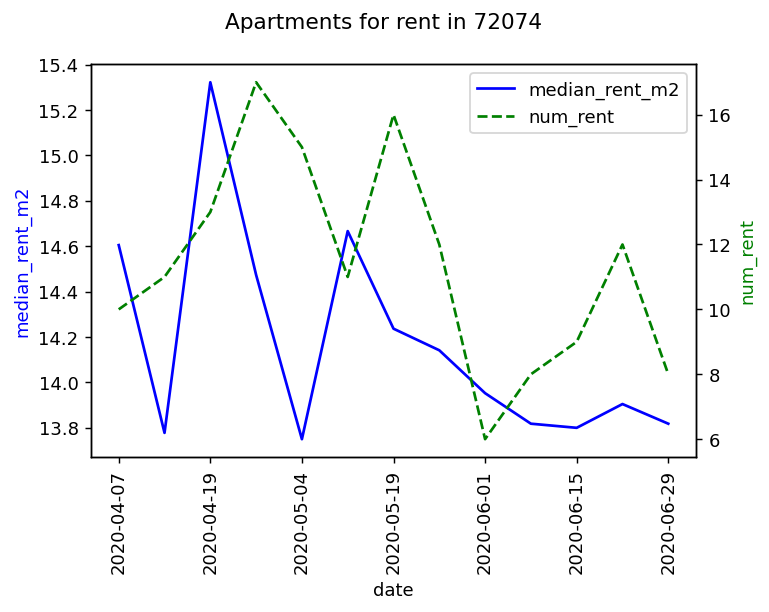

<IPython.core.display.Javascript object>

In [6]:
group_attributes = [72074]
feature1 = "median_rent_m2"
feature2 = "num_rent"

for attr in group_attributes:
    dp.plot_2features(time_df, "rent", attr, dates, feature1, feature2)

### 2.3) Apartments for sale

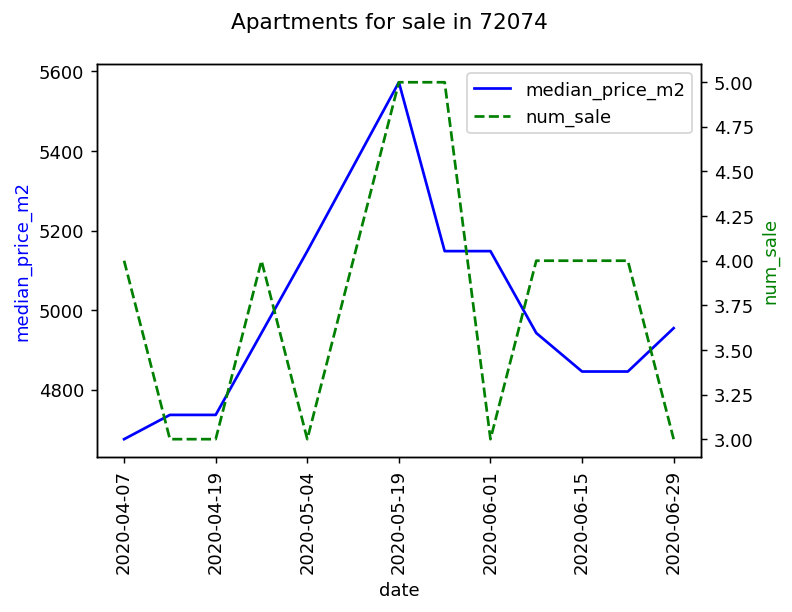

<IPython.core.display.Javascript object>

In [7]:
group_attributes = [72074]
feature1 = "median_price_m2"
feature2 = "num_sale"

for attr in group_attributes:
    dp.plot_2features(time_df, "sale", attr, dates, feature1, feature2)

### 2.4) Yearly rents divided by saleprice (Return of Investment - ROI)

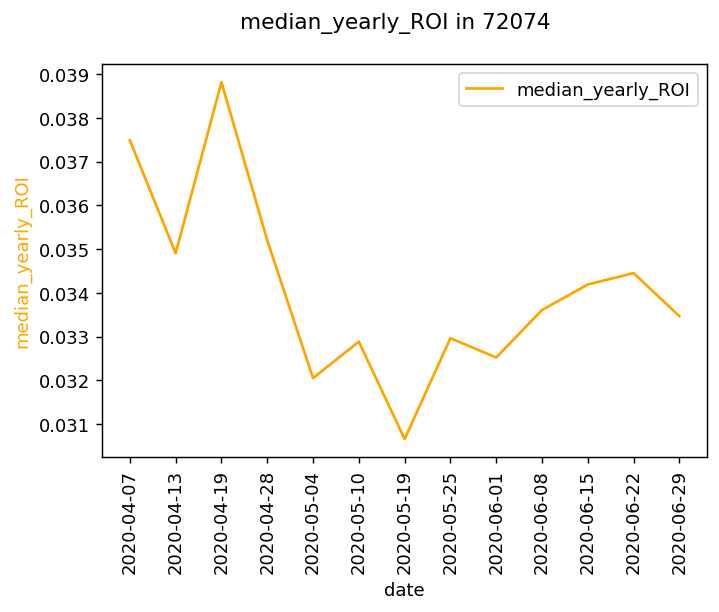

<IPython.core.display.Javascript object>

In [8]:
group_attributes = [72074]
feature1 = "median_yearly_ROI"

for attr in group_attributes:
    dp.plot_1feature(time_df, attr, dates, feature1)